In [ ]:
!pip install yfinance
!pip install prophet
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import yfinance as yf 
from prophet import Prophet
import pandas as pd
from datetime import datetime
import warnings
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error
from pmdarima.metrics import smape
from pandas.plotting import lag_plot

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
start_day = '2017-01-01'
end_day = datetime.now().date()

In [ ]:
def download_data(ticker='MSFT', start='2017-01-01', end=datetime.now().date()):
  data = yf.Ticker(ticker)
  hist = data.history(start=start, end=end) # 
  hist.reset_index(inplace=True)
  hist['Date'] = hist['Date'].dt.date
  # hist.rename(columns={'Date': 'datetime'}, inplace=True)
  return hist.iloc[:, :5]

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
def data_plot(data, cols, start='2017-01-01', end=datetime.now().date()):
  # plt.figure(figsize=(12, 7))
  fig, ax = plt.subplots(figsize=(12, 7))
  start = pd.to_datetime(start)
  end = pd.to_datetime(end)
  for col in cols:
    ax.plot(data[start: end][col], label=col, linewidth=2)
    # plt.plot(data[start: end][col], linewidth=5.0)
  plt.xlabel('date')  
  ax.legend()
  plt.show()

In [ ]:
# Pfizer download
df = download_data(ticker='PFE', start=start_day, end=end_day)

# df.drop(columns=['High', 'Low', 'Open'], inplace=True)
# df.columns = ['ds', 'y']
# df.ds = df.ds.dt.date
# df['date'] = df['datetime'].dt.date

In [ ]:
df.head()

,Date,Open,High,Low,Close
0,2017-01-03,25.098159,25.328417,25.013731,25.328417
1,2017-01-04,25.428195,25.597049,25.351441,25.550999
2,2017-01-05,25.612399,25.858008,25.420516,25.796606
3,2017-01-06,25.834978,25.865679,25.589370,25.696823
4,2017-01-09,25.658453,25.842659,25.620075,25.689154


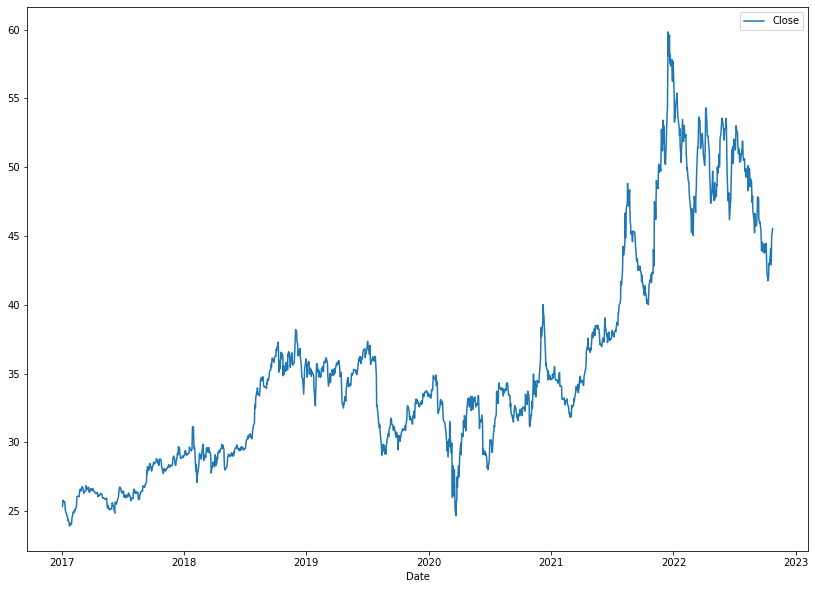

In [ ]:
df.plot(x='Date',y='Close', figsize=(14,10));

Split our data on test and split frame, in test will be data for one year

In [ ]:
train_len = df.shape[0] - 365
train_data, test_data = train_test_split(df, train_size=train_len)

y_train = train_data['Close'].values
y_test = test_data['Close'].values

print(f"{train_len} train samples")
print(f"{df.shape[0] - train_len} test samples")

1098 train samples
365 test samples


Check linear deoends between y(t) and y(t+1)

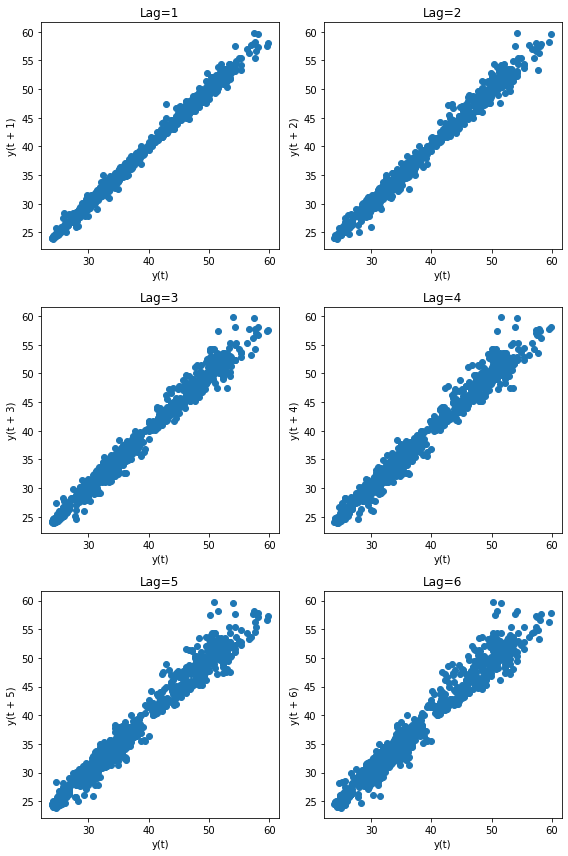

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(8, 12))
plt.title('Autocorrelation plot')

# The axis coordinates for the plots
ax_idcs = [
    (0, 0),
    (0, 1),
    (1, 0),
    (1, 1),
    (2, 0),
    (2, 1)
]

for lag, ax_coords in enumerate(ax_idcs, 1):
    ax_row, ax_col = ax_coords
    axis = axes[ax_row][ax_col]
    lag_plot(df['Close'], lag=lag, ax=axis)
    axis.set_title(f"Lag={lag}")

plt.tight_layout()
plt.show()

A linear shape to the plot suggests that an autoregressive model is probably a better choice.

we’ll use the KPSS test and ADF test, selecting the maximum value between the two to be conservative. 

In [ ]:
kpss_diffs = ndiffs(y_train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(y_train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


Fortunately, in this case, both tests indicated that 
d=1 was the best answer, but in the case where they disagreed, we could try both, selecting the best cross-validated result, or allow auto_arima to auto-select the d term.

now use auto arima for change parameters model

In [ ]:
auto = pm.auto_arima(y_train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, max_p=20, trace=2)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1365.369, Time=1.85 sec
First viable model found (1365.369)
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1366.488, Time=0.18 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1362.635, Time=0.09 sec
New best model found (1362.635 < 1365.369)
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1363.147, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1365.265, Time=0.11 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1362.508, Time=0.24 sec
New best model found (1362.508 < 1362.635)
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1363.879, Time=0.57 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1364.160, Time=1.31 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1363.516, Time=1.65 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1354.063, Time=3.32 sec
New best model found (1354.063 < 1362.508)
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1367.606, Time=1.15 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1344.875, Time=5.87 sec


In [ ]:
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1098
Model:               SARIMAX(3, 1, 2)   Log Likelihood                -665.855
Date:                Tue, 25 Oct 2022   AIC                           1343.710
Time:                        14:51:41   BIC                           1373.712
Sample:                             0   HQIC                          1355.062
                               - 1098                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7188      0.068    -25.170      0.000      -1.853      -1.585
ar.L2         -0.8229      0.084     -9.759      0.000      -0.988      -0.658
ar.L3          0.0239      0.025      0.961      0.337      -0.025       0.073
ma.L1          1.6704      0.064     26.194      0.000       1.545       1.795
ma.L2          0.7825      0.061     12.739      0.000       0.662       0.903
sigma2         0.1971      0.004     44.348      0.000       0.188       0.206
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1452.37
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               5.16   Skew:                            -0.49
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in y_test:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(y_test, forecasts)}")
print(f"SMAPE: {smape(y_test, forecasts)}")

Mean squared error: 0.7746893205603502
SMAPE: 1.3412943061365727


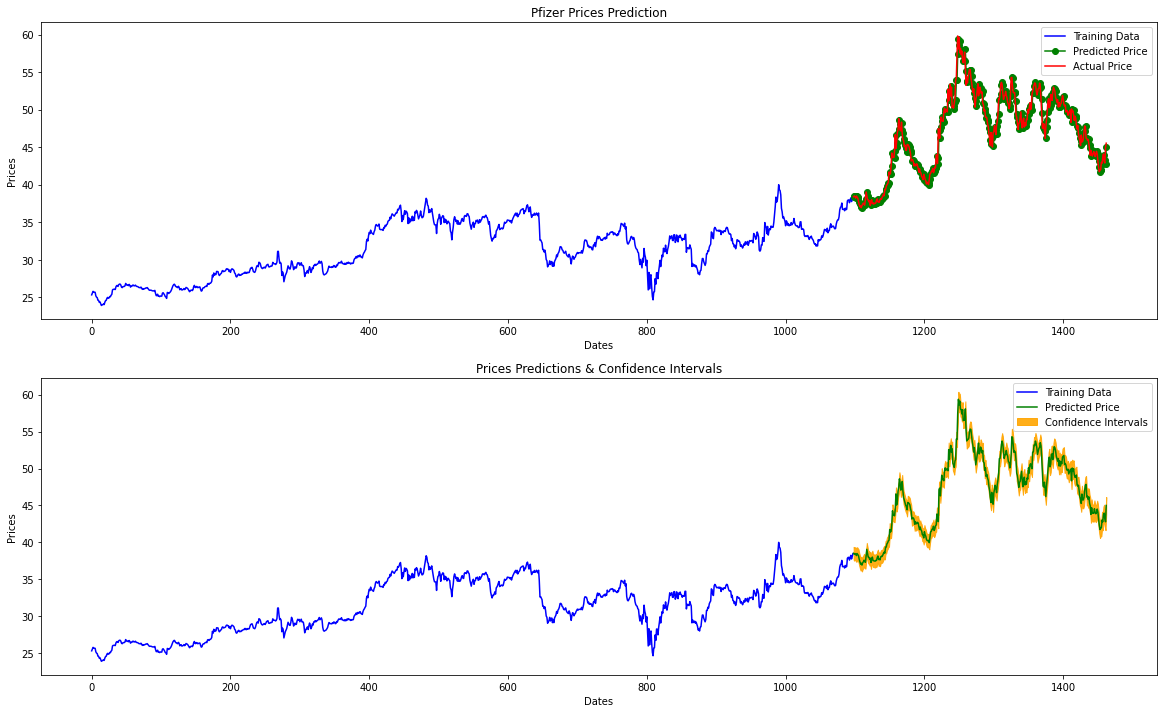

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# --------------------- Actual vs. Predicted --------------------------
axes[0].plot(y_train, color='blue', label='Training Data')
axes[0].plot(test_data.index, forecasts, color='green', marker='o',
             label='Predicted Price')

axes[0].plot(test_data.index, y_test, color='red', label='Actual Price')
axes[0].set_title('Pfizer Prices Prediction')
axes[0].set_xlabel('Dates')
axes[0].set_ylabel('Prices')

axes[0].legend()


# ------------------ Predicted with confidence intervals ----------------
axes[1].plot(y_train, color='blue', label='Training Data')
axes[1].plot(test_data.index, forecasts, color='green',
             label='Predicted Price')

axes[1].set_title('Prices Predictions & Confidence Intervals')
axes[1].set_xlabel('Dates')
axes[1].set_ylabel('Prices')

conf_int = np.asarray(confidence_intervals)
axes[1].fill_between(test_data.index,
                     conf_int[:, 0], conf_int[:, 1],
                     alpha=0.9, color='orange',
                     label="Confidence Intervals")

axes[1].legend()


plt.show()

how can we be sure that if we had predicted a year ago, then our forecast would have come true quite accurately

Check our model Prophet from Facebook

In [ ]:
df = download_data(ticker='PFE', start=start_day, end=end_day)

df.drop(columns=['High', 'Low', 'Open'], inplace=True)
df.columns = ['ds', 'y']

In [ ]:
df.head()

,ds,y
0,2017-01-03,25.328415
1,2017-01-04,25.550995
2,2017-01-05,25.796604
3,2017-01-06,25.696823
4,2017-01-09,25.689152


In [ ]:
train_len = int(df.shape[0] * 0.8)
train_data, test_data = train_test_split(df, train_size=train_len)

In [ ]:
# declaring the model, it's necessary to pay attention to seasonality type we want to use
model = Prophet(growth='linear', seasonality_mode='additive')
model.fit(train_data)

# creating one more specific dataset for predictions
# we also need to set data frequency here (by default - days)
future = model.make_future_dataframe(periods=len(test_data), freq='D')
future.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpav_hcrxu/uyjsd5ow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpav_hcrxu/txbz_40u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51762', 'data', 'file=/tmp/tmpav_hcrxu/uyjsd5ow.json', 'init=/tmp/tmpav_hcrxu/txbz_40u.json', 'output', 'file=/tmp/tmpav_hcrxu/prophet_modeljo6jo5r8/prophet_model-20221025145305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:53:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:53:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds
1458,2022-06-10
1459,2022-06-11
1460,2022-06-12
1461,2022-06-13
1462,2022-06-14


In [ ]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1458,2022-06-10,49.113941,44.830378,53.012074,45.794570,52.839513,-0.478467,-0.478467,-0.478467,0.203178,0.203178,0.203178,-0.681645,-0.681645,-0.681645,0.0,0.0,0.0,48.635474
1459,2022-06-11,49.142175,44.282008,52.337539,45.802725,52.883287,-1.125752,-1.125752,-1.125752,-0.422550,-0.422550,-0.422550,-0.703202,-0.703202,-0.703202,0.0,0.0,0.0,48.016423
1460,2022-06-12,49.170409,44.280010,52.437446,45.810880,52.927061,-1.146288,-1.146288,-1.146288,-0.422550,-0.422550,-0.422550,-0.723738,-0.723738,-0.723738,0.0,0.0,0.0,48.024121
1461,2022-06-13,49.198643,44.855126,52.998845,45.820590,52.970835,-0.541392,-0.541392,-0.541392,0.201571,0.201571,0.201571,-0.742964,-0.742964,-0.742964,0.0,0.0,0.0,48.657251
1462,2022-06-14,49.226877,44.712244,52.931817,45.837131,53.014609,-0.587503,-0.587503,-0.587503,0.173098,0.173098,0.173098,-0.760601,-0.760601,-0.760601,0.0,0.0,0.0,48.639373


Mean absolute percentage error for test 9.52%
Mean absolute percentage error for train 3.46%


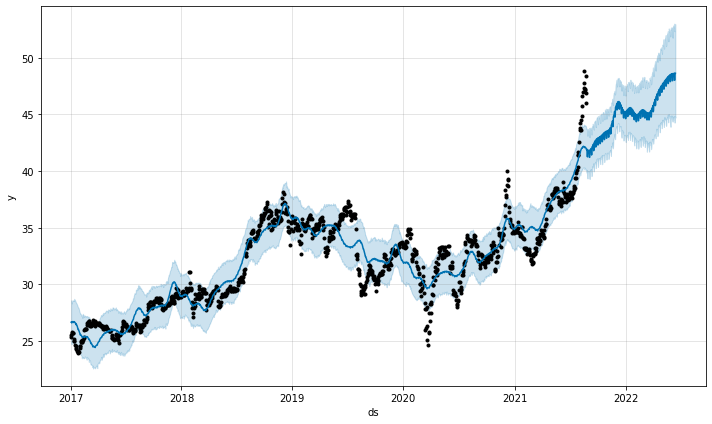

In [ ]:
# pictures!
error_test = mean_absolute_percentage_error(df[-len(test_data):]['y'], forecast[-len(test_data):]['yhat'])
error_train = mean_absolute_percentage_error(df[:-len(test_data)]['y'], forecast[:-len(test_data)]['yhat'])
print("Mean absolute percentage error for test {0:.2f}%".format(error_test))
print("Mean absolute percentage error for train {0:.2f}%".format(error_train))
_ = model.plot(forecast)

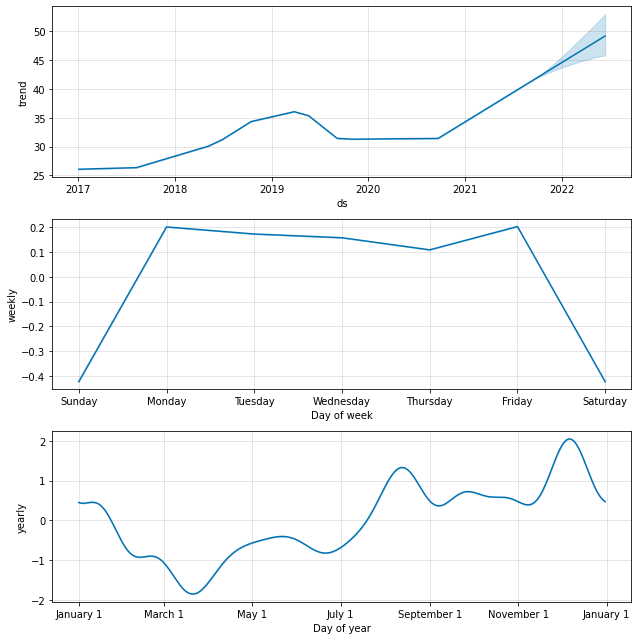

In [ ]:
_ = model.plot_components(forecast)

As we can see on the charts above, there is a general upward trend.

As we can see, rmse on the training set is very low, but on the delayed model it behaves somewhat worse. But let's build a model for 1 year ahead. In general, the model coped quite well. 

In [ ]:
future = model.make_future_dataframe(periods=len(test_data) + 365, freq='D')
future.tail()

,ds
1823,2023-06-10
1824,2023-06-11
1825,2023-06-12
1826,2023-06-13
1827,2023-06-14


In [ ]:
forecast = model.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1823,2023-06-10,59.419297,45.381776,70.477609,47.011478,71.649119,-1.098682,-1.098682,-1.098682,-0.422550,-0.422550,-0.422550,-0.676132,-0.676132,-0.676132,0.0,0.0,0.0,58.320615
1824,2023-06-11,59.447530,45.044155,70.372637,47.018947,71.713328,-1.120447,-1.120447,-1.120447,-0.422550,-0.422550,-0.422550,-0.697897,-0.697897,-0.697897,0.0,0.0,0.0,58.327083
1825,2023-06-12,59.475764,46.197115,71.282902,47.030243,71.777537,-0.517144,-0.517144,-0.517144,0.201571,0.201571,0.201571,-0.718716,-0.718716,-0.718716,0.0,0.0,0.0,58.958620
1826,2023-06-13,59.503998,46.003836,71.412140,47.037065,71.844488,-0.565198,-0.565198,-0.565198,0.173098,0.173098,0.173098,-0.738296,-0.738296,-0.738296,0.0,0.0,0.0,58.938801
1827,2023-06-14,59.532232,46.198218,71.332969,47.034845,71.918383,-0.598326,-0.598326,-0.598326,0.158029,0.158029,0.158029,-0.756355,-0.756355,-0.756355,0.0,0.0,0.0,58.933906


Plot Prophet model with prediction on 1 year

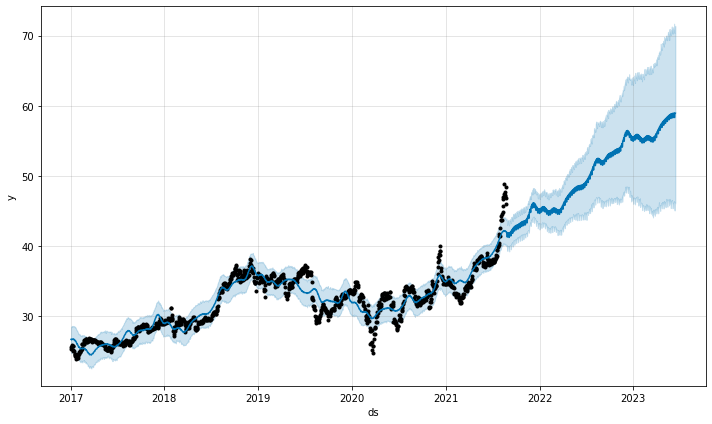

In [ ]:
_ = model.plot(forecast)

both models are autoregressive, but Prophet is easier to work with. Model accuracy is similar